In [1]:
from astropy.io import fits
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [2]:
pwd

'/home/christian/Documents/magistrale/ab_inf'

In [3]:
#importante per decidere quale set di misure viene letto!
test=1

In [4]:
#i dataset hanno parametri di distribuzione diversi
if test==1:
    sigs = [0.02, 0.02, 0.02]
    ls = [25, 50, 75]
elif test==2:
    sigs = [0.02, 0.01, 0.005]
    ls = [50, 50, 50]
else:
    sigs = [0.02, 0.01, 0.005]
    ls = [5, 5, 5]

In [5]:
TEST_COVARIANCE=False
PLOTS=True

In [6]:
#fa una matrice NmeasuresxNbins leggendo i dati
Nbins=200
Nmeasures=10000
measures=[]
measures2=[]
measures4=[]
for i in np.arange(Nmeasures)+1:
    fname= f'./data/MockMeasures_2PCF_Test{test}/MockMeasures_2PCF_Correlation_MULTIPOLES_Test{test}_{i}.fits'
    #print(f'apro il file N.{i} chiamato {fname}')
    
    file=fits.open(fname)
    #file.info()
    table=file[1].data.copy()
    measures.append(table['XI0'])
    measures2.append(table['XI2'])
    measures4.append(table['XI4'])    
    if i==1:
        scale =table['SCALE'] #midpoint of every bin
    del table
    file.close()
measures=np.asarray(measures)#shape is (Nmeasures, Nbins)
measures2=np.asarray(measures2)
measures4=np.asarray(measures4)

In [7]:
# creating a matrix containing multipoles 0 2 4 in sequence. shape is (Nmeasures, 3*Nbins)
measurestot=np.concatenate((measures, measures2, measures4), axis=1)

In [8]:
#calcolo media e covarianza
tmeasures=np.asarray(measures).transpose()#trasposizione per usare il comando da libreria
tmeasures2=np.asarray(measures2).transpose()
tmeasures4=np.asarray(measures4).transpose()
mean_xi   = np.mean(tmeasures,axis=1) #media sul primo indice di measures
cov_xi = np.cov(tmeasures)

In [9]:
tmeasurestot=np.asarray(measurestot).transpose()
mean_xi_tot=np.mean(tmeasurestot, axis=1)
cov_xi_tot=np.cov(tmeasurestot)

In [10]:
#implementazione del calcolo della media e della covarianza senza la libreria numpy
if TEST_COVARIANCE:
    print('Running test to see if I understand the covariance:')
    
    SUM = np.zeros((Nbins,Nbins),dtype=float)
    AVE = np.zeros((Nbins,),dtype=float)
    cov = np.zeros((Nbins,Nbins),dtype=float)

    for i in range(Nmeasures):
        AVE += measures[i,:]
    AVE = AVE/Nmeasures
    print(len(AVE))
    for i in range(Nbins):
        for j in range(Nbins):
            for l in range(Nmeasures):
                cov[i,j] += (measures[l,i]-AVE[i])*(measures[l,j]-AVE[j])
            #cov[i,j] = (np.sum(tmeasures[i]*tmeasures[j]) - AVE[i]*AVE[j]*Nmeasures) / (Nmeasures-1)
    cov/=Nmeasures
    print('Largest deviation between my calculation and numpy: {}'.format(np.max(np.abs(cov-cov_xi))))

In [11]:
# definition for correlation
def corr(x1):
    co = np.zeros(np.shape(x1),dtype=float)
    for i in range(len(x1[1,:])):
        for j in range(len(x1[:,1])):
            co[i,j]=x1[i,j]/(x1[i,i]*x1[j,j])**0.5
    return co

In [12]:
# definition for cross covariance between different multipoles
def crcov(x1,x2):
    co = np.zeros((Nbins,Nbins),dtype=float)
    x1=np.asarray(x1).transpose()
    x2=np.asarray(x2).transpose()
    for i in range(Nbins):
        for j in range(Nbins):
            co[i,j] = np.mean(x1[i]*x2[j]) - np.mean(x1[i]) * np.mean(x2[j])
    return co

In [13]:
corr_xi= corr(cov_xi)

In [14]:
# correlation matrix NOT NECESSARY ANYMORE
if TEST_COVARIANCE:
    corr_xi = np.zeros((Nbins,Nbins),dtype=float)
    for i in range(Nbins):
        for j in range(Nbins):
            corr_xi[i,j]=cov_xi[i,j]/(cov_xi[i,i]*cov_xi[j,j])**0.5
    corre=corr(cov_xi)
    print('Largest deviation between my calculation and routine: {}'.format(np.max(np.abs(corr_xi-corre))))

In [15]:
## Definitions to build the covarince matrices based on Squared Exponential kernel
def covf(x1, x2, sig, l): #x1, x2 are (1d)pixel's number, they range from 0.5 to 199.5 
    return sig**2.*np.exp(-(x1 - x2)**2./(2.*l**2.))
#subroutine per covarianza tra multipoli diversi (?)
def covf1f2(x1, x2, sig1, l1, sig2, l2):
    return (np.sqrt(2.*l1*l2)*np.exp(-(np.sqrt((x1 - x2)**2.)**2./(l1**2. + l2**2.)))*sig1*sig2)/np.sqrt(l1**2. + l2**2.)

In [16]:
cov_th = np.zeros((Nbins,Nbins),dtype=float)
for i in range(Nbins):
    for j in range(Nbins):
        cov_th[i,j] = covf(scale[i],scale[j],sigs[0],ls[0])

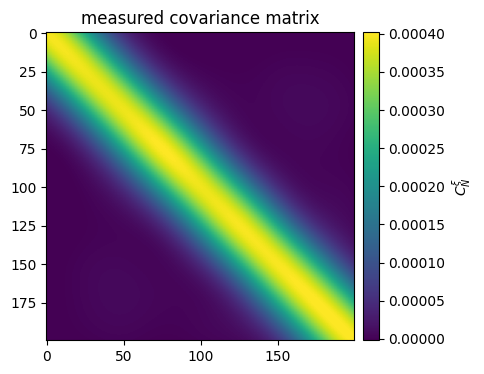

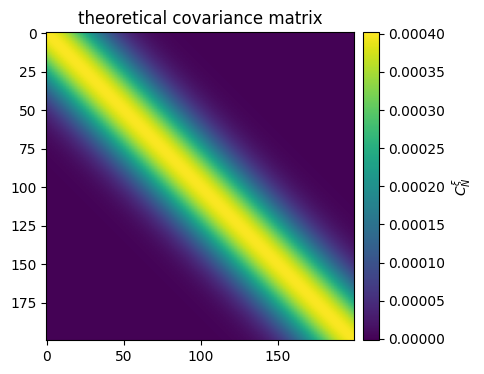

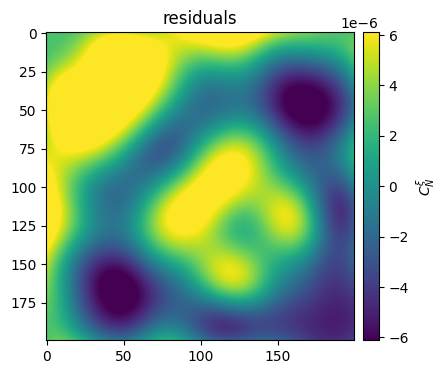

In [17]:
if PLOTS:

    gratio = (1. + 5. ** 0.5) / 2.

    dpi = 300
    #climit=max(np.max(theoretical_covariance),np.max(measured_covariance))
    cmin = -np.max(cov_th)*0.005
    cmax =  np.max(cov_th)*1.005

    # Matrix plot of measured covariance matrix
    fig = plt.figure(figsize=(6,4))
    plt.title('measured covariance matrix')
    plt.imshow(cov_xi, vmin=cmin, vmax=cmax)
    cbar = plt.colorbar(orientation="vertical", pad=0.02)
    cbar.set_label(r'$ C^{\xi}_{N}$')
    # PLOTNAME = 'Test%s_Measured_Matrix.png'%test
    # plt.savefig(PLOTNAME,dpi = dpi)
    plt.show()


    # Matrix plot of theoretical covariance matrix
    fig = plt.figure(figsize=(6,4))
    plt.title('theoretical covariance matrix')
    plt.imshow(cov_th, vmin=cmin, vmax=cmax)
    cbar = plt.colorbar(orientation="vertical", pad=0.02)
    cbar.set_label(r'$ C^{\xi}_{N}$')
    # PLOTNAME = 'Test%s_Measured_Matrix.png'%test
    # plt.savefig(PLOTNAME,dpi = dpi)
    plt.show()
    
    #adjusting the scale to better visualize the residuals
    cmin = np.min(cov_th-cov_xi)*0.85
    cmax =  np.max(cov_th-cov_xi)*1.15

    # Matrix plot of theoretical covariance matrix
    fig = plt.figure(figsize=(6,4))
    plt.title('residuals')
    plt.imshow(cov_th-cov_xi, vmin=cmin, vmax=-cmin)
    cbar = plt.colorbar(orientation="vertical", pad=0.02)
    cbar.set_label(r'$ C^{\xi}_{N}$')
    # PLOTNAME = 'Test%s_Measured_Matrix.png'%test
    # plt.savefig(PLOTNAME,dpi = dpi)
    plt.show()

In [18]:
norm_residuals = np.zeros_like(cov_th)
for i in range(Nbins):
    for j in range(Nbins):
        rho2 = cov_th[i,j]**2./(np.sqrt(cov_th[i,i]*cov_th[j,j])**2.)
        norm_residuals[i,j]=(cov_th[i,j]-cov_xi[i,j])*np.sqrt((Nmeasures-1.)/((1.+rho2)*cov_th[i,i]*cov_th[j,j]))

rms_deviation=np.std(norm_residuals.reshape(Nbins**2))

print(f"rms deviation of normalized residuals: {rms_deviation}")

if rms_deviation<1.1:
    print("**********")
    print("* PASSED *")
    print("**********")
else:
    print("!!!!!!!!!!")
    print("! FAILED !")
    print("!!!!!!!!!!")

rms deviation of normalized residuals: 0.9798930484453547
**********
* PASSED *
**********


In [19]:
#calcolo media e covarianza multipolo 2
tmeasures2=np.asarray(measures2).transpose()#trasposizione per usare il comando da libreria
mean_xi2   = np.mean(tmeasures2,axis=1) #media sul primo indice di measures
cov_xi2 = np.cov(tmeasures2)

In [20]:
# correlation matrix 2nd multipole
corr_xi2 = np.zeros((Nbins,Nbins),dtype=float)
for i in range(Nbins):
    for j in range(Nbins):
        corr_xi2[i,j]=cov_xi2[i,j]/(cov_xi2[i,i]*cov_xi2[j,j])**0.5

In [21]:
cov_th2 = np.zeros((Nbins,Nbins),dtype=float)
for i in range(Nbins):
    for j in range(Nbins):
        cov_th2[i,j] = covf(scale[i],scale[j],sigs[1],ls[1])

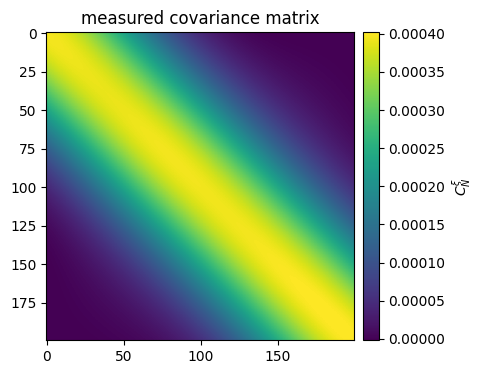

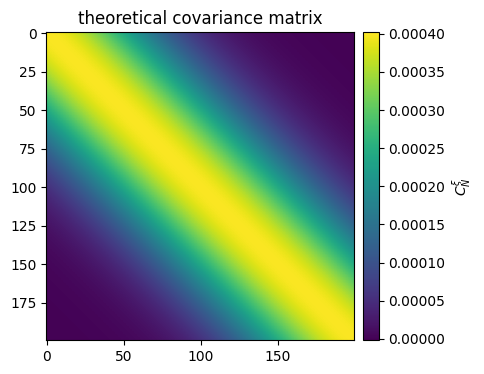

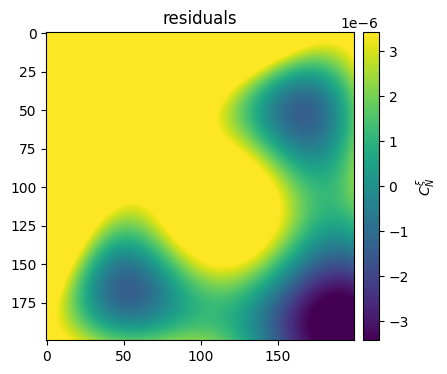

In [22]:
if PLOTS:

    gratio = (1. + 5. ** 0.5) / 2.

    dpi = 300
    #climit=max(np.max(theoretical_covariance),np.max(measured_covariance))
    cmin = -np.max(cov_th2)*0.005
    cmax =  np.max(cov_th2)*1.005

    # Matrix plot of measured covariance matrix
    fig = plt.figure(figsize=(6,4))
    plt.title('measured covariance matrix')
    plt.imshow(cov_xi2, vmin=cmin, vmax=cmax)
    cbar = plt.colorbar(orientation="vertical", pad=0.02)
    cbar.set_label(r'$ C^{\xi}_{N}$')
    # PLOTNAME = 'Test%s_Measured_Matrix.png'%test
    # plt.savefig(PLOTNAME,dpi = dpi)
    plt.show()


    # Matrix plot of theoretical covariance matrix
    fig = plt.figure(figsize=(6,4))
    plt.title('theoretical covariance matrix')
    plt.imshow(cov_th2, vmin=cmin, vmax=cmax)
    cbar = plt.colorbar(orientation="vertical", pad=0.02)
    cbar.set_label(r'$ C^{\xi}_{N}$')
    # PLOTNAME = 'Test%s_Measured_Matrix.png'%test
    # plt.savefig(PLOTNAME,dpi = dpi)
    plt.show()

    cmin = np.min(cov_th2-cov_xi2)*0.85
    cmax =  np.max(cov_th2-cov_xi2)*1.15
    
    # Matrix plot of residuals
    fig = plt.figure(figsize=(6,4))
    plt.title('residuals')
    plt.imshow(cov_th2-cov_xi2, vmin=cmin, vmax=-cmin)
    cbar = plt.colorbar(orientation="vertical", pad=0.02)
    cbar.set_label(r'$ C^{\xi}_{N}$')
    # PLOTNAME = 'Test%s_Measured_Matrix.png'%test
    # plt.savefig(PLOTNAME,dpi = dpi)
    plt.show()

In [23]:
#theoretical cross-covariance multipole 0 2
cov_th02 = np.zeros((Nbins,Nbins),dtype=float)
for i in range(Nbins):
    for j in range(Nbins):
        cov_th02[i,j] = covf1f2(scale[i],scale[j],sigs[0],ls[0],sigs[1],ls[1])

In [24]:
#calculated cross-covariance multipole 0 2
crcov_02=crcov(measures, measures2)

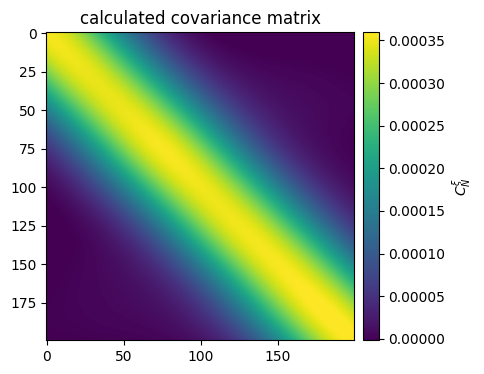

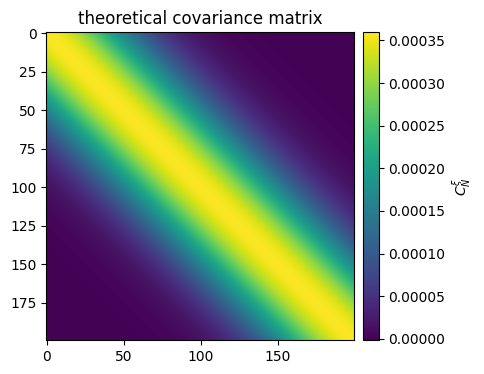

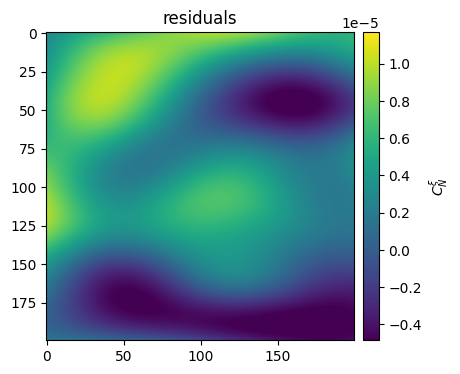

In [25]:
if PLOTS:

    gratio = (1. + 5. ** 0.5) / 2.

    dpi = 300
    #climit=max(np.max(theoretical_covariance),np.max(measured_covariance))
    cmin = -np.max(cov_th02)*0.005
    cmax =  np.max(cov_th02)*1.005
    
    # Matrix plot of theoretical covariance matrix
    fig = plt.figure(figsize=(6,4))
    plt.title('calculated covariance matrix')
    plt.imshow(crcov_02, vmin=cmin, vmax=cmax)
    cbar = plt.colorbar(orientation="vertical", pad=0.02)
    cbar.set_label(r'$ C^{\xi}_{N}$')
    # PLOTNAME = 'Test%s_Measured_Matrix.png'%test
    # plt.savefig(PLOTNAME,dpi = dpi)
    plt.show()
    
    # Matrix plot of theoretical covariance matrix
    fig = plt.figure(figsize=(6,4))
    plt.title('theoretical covariance matrix')
    plt.imshow(cov_th02, vmin=cmin, vmax=cmax)
    cbar = plt.colorbar(orientation="vertical", pad=0.02)
    cbar.set_label(r'$ C^{\xi}_{N}$')
    # PLOTNAME = 'Test%s_Measured_Matrix.png'%test
    # plt.savefig(PLOTNAME,dpi = dpi)
    plt.show()
    
    cmin =  np.min(cov_th02-crcov_02)*0.85
    cmax =  np.max(cov_th02-crcov_02)*1.15
    
    # Matrix plot of residuals
    fig = plt.figure(figsize=(6,4))
    plt.title('residuals')
    plt.imshow(cov_th02-crcov_02, vmin=cmin, vmax=cmax)
    cbar = plt.colorbar(orientation="vertical", pad=0.02)
    cbar.set_label(r'$ C^{\xi}_{N}$')
    # PLOTNAME = 'Test%s_Measured_Matrix.png'%test
    # plt.savefig(PLOTNAME,dpi = dpi)
    plt.show()

In [26]:
#theoretical calculation of covariance and cross-covariance for higher multipole order
cov_th_tot=np.zeros_like(cov_xi_tot)
for n in range(3):
    for m in range(3):
        for i in range(Nbins):
            for j in range(Nbins):
                cov_th_tot[i+200*n,j+200*m]=covf1f2(scale[i],scale[j],sigs[n],ls[n],sigs[m],ls[m])
#def covf1f2(x1, x2, sig1, l1, sig2, l2):
#    return (np.sqrt(2.*l1*l2)*np.exp(-(np.sqrt((x1 - x2)**2.)**2./(l1**2. + l2**2.)))*sig1*sig2)/np.sqrt(l1**2. + l2**2.)

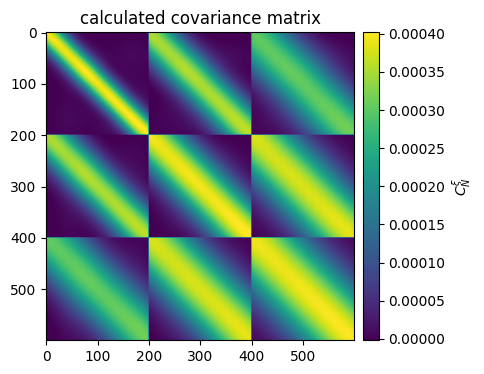

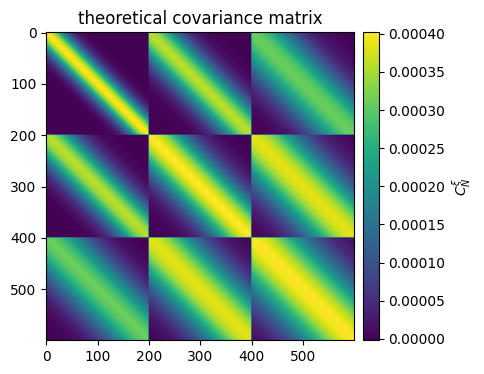

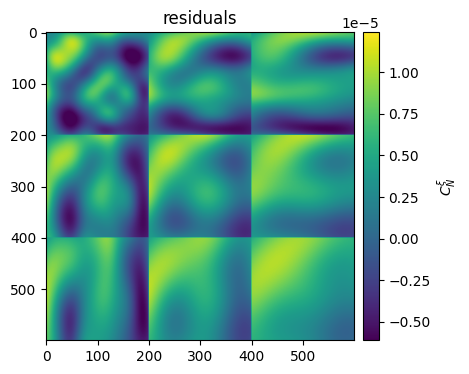

In [27]:
if PLOTS:

    gratio = (1. + 5. ** 0.5) / 2.

    dpi = 300
    #climit=max(np.max(theoretical_covariance),np.max(measured_covariance))
    cmin = -np.max(cov_th_tot)*0.005
    cmax =  np.max(cov_th_tot)*1.005
    
    # Matrix plot of theoretical covariance matrix
    fig = plt.figure(figsize=(6,4))
    plt.title('calculated covariance matrix')
    plt.imshow(cov_xi_tot, vmin=cmin, vmax=cmax)
    cbar = plt.colorbar(orientation="vertical", pad=0.02)
    cbar.set_label(r'$ C^{\xi}_{N}$')
    # PLOTNAME = 'Test%s_Measured_Matrix.png'%test
    # plt.savefig(PLOTNAME,dpi = dpi)
    plt.show()
    
    # Matrix plot of theoretical covariance matrix
    fig = plt.figure(figsize=(6,4))
    plt.title('theoretical covariance matrix')
    plt.imshow(cov_th_tot, vmin=cmin, vmax=cmax)
    cbar = plt.colorbar(orientation="vertical", pad=0.02)
    cbar.set_label(r'$ C^{\xi}_{N}$')
    # PLOTNAME = 'Test%s_Measured_Matrix.png'%test
    # plt.savefig(PLOTNAME,dpi = dpi)
    plt.show()
    
    cmin = np.min(cov_th_tot-cov_xi_tot)*0.85
    cmax =  np.max(cov_th_tot-cov_xi_tot)*1.15
    
    # Matrix plot of residuals
    fig = plt.figure(figsize=(6,4))
    plt.title('residuals')
    plt.imshow(cov_th_tot-cov_xi_tot, vmin=cmin, vmax=cmax)
    cbar = plt.colorbar(orientation="vertical", pad=0.02)
    cbar.set_label(r'$ C^{\xi}_{N}$')
    # PLOTNAME = 'Test%s_Measured_Matrix.png'%test
    # plt.savefig(PLOTNAME,dpi = dpi)
    plt.show()

In [28]:
norm_residuals_tot = np.zeros_like(cov_th_tot)
for i in range(3*Nbins):
    for j in range(3*Nbins):
        rho2 = cov_th_tot[i,j]**2./(np.sqrt(cov_th_tot[i,i]*cov_th_tot[j,j])**2.)
        norm_residuals_tot[i,j]=(cov_th_tot[i,j]-cov_xi_tot[i,j])*np.sqrt((Nmeasures-1.)/((1.+rho2)*cov_th_tot[i,i]*cov_th_tot[j,j]))

rms_deviation=np.std(norm_residuals_tot.reshape(9*Nbins**2))

print(f"rms deviation of normalized residuals: {rms_deviation}")

if rms_deviation<1.1:
    print("**********")
    print("* PASSED *")
    print("**********")
else:
    print("!!!!!!!!!!")
    print("! FAILED !")
    print("!!!!!!!!!!")

rms deviation of normalized residuals: 0.8752953222683345
**********
* PASSED *
**********
